In [1]:
import matplotlib.pyplot as plt
import numpy as np
import veloxchem as vlx
from scipy.interpolate import interp1d
import py3Dmol as p3d
from matplotlib import gridspec


# Conversion factor
au2ev = 27.211386

# ==== 1. Define molecule ====
#smiles = "O=C1OC(C2=C1C=CC=C2)(C3=CC=C(C=C3)O[H])C4=CC=C(C=C4)O[H]"
#phen = vlx.Molecule.read_smiles(smiles)

phen = vlx.Molecule.read_xyz_file("Phenolphthalein_Optimized.xyz")

phen.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
basis = vlx.MolecularBasis.read(phen, 'def2-tzvp')

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.filename = 'phen-scf-smd'
scf_drv.xcfun = 'cam-b3lyp'
#scf_drv.solvation_model = 'smd'
#scf_drv.smd_solvent = 'ethanol'
scf_drv.dispersion = True
results = scf_drv.compute(phen, basis)

opt_drv = vlx.OptimizationDriver(scf_drv)
opt_drv.filename = 'phen-opt-smd'
opt_drv.keep_files = True
opt_results = opt_drv.compute(phen, basis, results)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'phen-scf-smd.log'

In [30]:
opt_drv.show_convergence(opt_results)

interactive(children=(IntSlider(value=19, description='step', max=19), Output()), _dom_classes=('widget-intera…

In [16]:
import veloxchem as vlx
import py3Dmol as p3d
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets
import h5py

In [31]:
def read_xyz_file(file_name):
    """Reads all the configurations from an xyz geometry optimization file."""
    xyz_file = open(file_name, "r")
    data = xyz_file.read()
    xyz_file.close()
    
    xyz_file = open(file_name, "r")
    i = 0
    steps = []
    energies = []
    for line in xyz_file:
        if "Energy" in line:
            steps.append(i)
            i += 1
            parts = line.split()
            energy = float(parts[-1])
            energies.append(energy)
    xyz_file.close()
    
    return data, steps, energies

def read_xyz_index(file_name, index=0):
    """Reads one configuration defined by its index from the xyz optimization file."""
    xyz_file = open(file_name, "r")
    current_index = 0
    data = ""

    # Read the number of atoms from the first line
    line = xyz_file.readline()
    natm = line.split()[0]
    data += line
    for line in xyz_file:
        if index == current_index:
            data += line
            if 'Energy' in line:
                parts = line.split()
                energy = float(parts[-1])
        if natm in line:
            parts = line.split()
            if len(parts) == 1:
                if index == current_index:
                    break
                current_index += 1
    xyz_file.close()
    return data, energy


def return_viewer(file_name, step=0):
    xyz_data_i, energy_i = read_xyz_index(file_name, step)
    
    # Uncomment if you would also like to see the energy plot
    # or comment out if you would like to skip this.
    # plt.figure(figsize=(7,4))
    # plt.plot(steps, energies, 'o--')
    # plt.plot(step, energy_i, 'o', markersize=15)
    # plt.xlabel('Iteration')
    # plt.ylabel('Energy (H)')
    # plt.title("Phenolphthalein optimization")
    # plt.tight_layout(); plt.show()
    
    viewer = p3d.view(width=600, height=300)
    viewer.addModel(xyz_data_i)
    viewer.setViewStyle({"style": "outline", "width": 0.05})
    viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})
    viewer.show()

In [32]:
xyz_file_name = 'mol-opt_optim.xyz'
xyz_data, steps, energies = read_xyz_file(xyz_file_name)

# # Plot the energies
# plt.figure(figsize=(7,4))
# plt.plot(steps, energies,'o--')
# plt.xlabel('Iteration')
# plt.ylabel('Energy (H)')
# plt.title("Phenolphthalein optimization")
# plt.tight_layout(); plt.show()

# and animate the optimization
viewer = p3d.view(width=600, height=300)
viewer.addModelsAsFrames(xyz_data)
viewer.animate({"loop": "forward"})

viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})

viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [35]:
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.xcfun = 'CAM-B3LYP'
scf_results = scf_drv.compute(phen, basis)



rsp_drv = vlx.lreigensolver.LinearResponseEigenSolver()
rsp_drv.nstates = 10
rsp_drv.filename = 'mol-rsp'
rsp_results = rsp_drv.compute(phen, basis, scf_results)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [42]:
au2ev = 27.211386

# Print results as a table
print("Energy [au]  Osc. str.   TM(x)     TM(y)     TM(z)")
for i in np.arange(len(rsp_results["eigenvalues"])):
    e, os, x, y, z = (
        rsp_results["eigenvalues"][i],
        rsp_results["oscillator_strengths"][i],
        rsp_results["electric_transition_dipoles"][i][0],
        rsp_results["electric_transition_dipoles"][i][1],
        rsp_results["electric_transition_dipoles"][i][2],
    )
    print("   {:.3f}     {:8.5f}  {:8.5f}  {:8.5f}  {:8.5f}".format(1240/(e* au2ev), os, x, y, z))


Energy [au]  Osc. str.   TM(x)     TM(y)     TM(z)
   272.170      0.00015  -0.00299  -0.03602  -0.00482
   252.237      0.03785   0.23245   0.16321   0.48329
   243.067      0.03575   0.15158  -0.48925  -0.15405
   240.930      0.02254  -0.30113  -0.12092  -0.27106
   232.804      0.02823  -0.20182   0.05632  -0.41526
   225.050      0.04592   0.10698   0.32850  -0.46988
   219.417      0.05136  -0.00959   0.19832   0.57578
   214.817      0.17900  -1.03710   0.21328  -0.38034
   211.046      0.17068  -0.65853  -0.79560   0.34511
   203.968      0.05029   0.36834  -0.25531   0.36988


In [ ]:
205nm, 229nm, 276nm

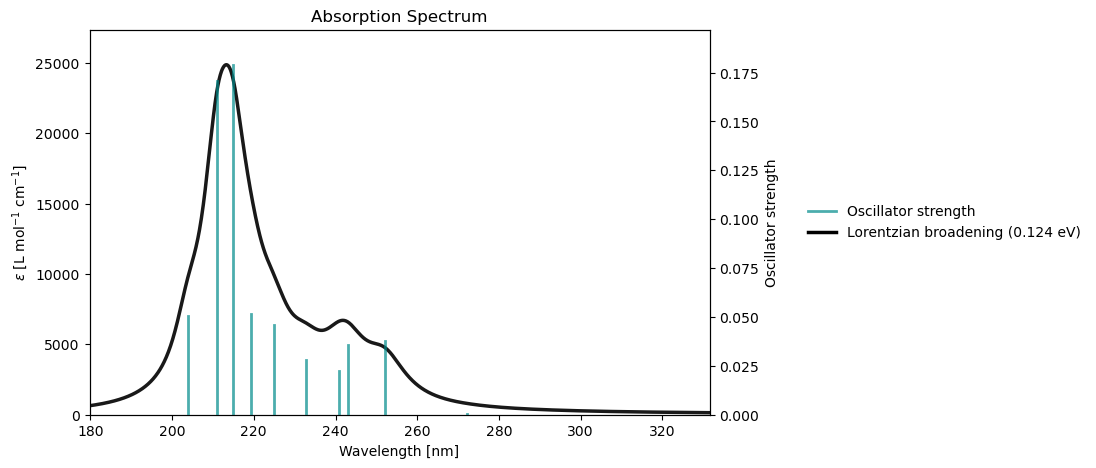

In [ ]:
rsp_drv.plot(rsp_results, plot_type="uv")

In [44]:
viewer = vlx.OrbitalViewer()
viewer.plot(phen, basis, scf_drv.mol_orbs)

                                                                                                                          
               Iter. |    Kohn-Sham Energy | Energy Change | Gradient Norm | Max. Gradient | Density Change               
               --------------------------------------------------------------------------------------------               


Output()

Dropdown(description='Orbital:', index=82, options=(('  1 occ=2.000 ene=-19.250  (alpha HOMO-82)', 0), ('  2 o…

In [ ]:
phen_opt = vlx.Molecule.read_xyz_string(opt_results['final_geometry'])

basis = vlx.MolecularBasis.read(phen, 'def2-svp')

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.filename = 'mol-opt'
scf_drv.xcfun = 'cam-b3lyp'
scf_drv.solvation_model = 'smd'
scf_drv.smd_solvent = 'ethanol'
scf_drv.dispersion = True
scf_results = scf_drv.compute(phen, basis)

rsp_drv = vlx.lreigensolver.LinearResponseEigenSolver()
rsp_drv.nstates = 4
rsp_drv.filename = 'mol-rsp'
rsp_results = rsp_drv.compute(phen, basis, scf_results)